Based off of notebooks graph-rerf.ipynb and s-rerf.ipynb in https://github.com/neurodata/j1c/tree/master/notebooks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# from sklearn.neighbors import KNeighborsClassifier

from graspy.simulations import sbm
# from graspy.embed import MultipleASE, OmnibusEmbed
# from graspy.plot import heatmap, pairplot

from rerf.rerfClassifier import rerfClassifier

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

### Generating Samples

We will generate 10 graphs each from four different population of stochastic block models (SBMs), which represent four classes. Each graph has 64 vertices, and the four classes have the following block matrices:

$$B^{(k)} = 0.25(\mathbb{1}\mathbb{1}^T) + \alpha C^{(k)}$$ where

$$
C^{(1)} = \begin{bmatrix} 
.1 & 0 \\
0 & .1
\end{bmatrix}
\quad
C^{(2)} = -\begin{bmatrix} 
.1 & 0 \\
0 & .1
\end{bmatrix}
\quad
C^{(3)} = \begin{bmatrix} 
.1 & 0 \\
0 & 0
\end{bmatrix}
\quad
C^{(4)} = \begin{bmatrix} 
0 & 0 \\
0 & .1
\end{bmatrix}
\quad
$$

In [2]:
def generate_data(n=10, alpha=0.1, seed=None):
    np.random.seed(seed)
    
    C1 = [[.1, 0],
          [0, .1]]
    C2 = [[-.1, 0],
          [0, -.1]]
    C3 = [[.1, 0],
          [0, 0]]
    C4 = [[0, 0],
          [0, .1]]
    
    ones = np.ones((2, 2)) * .25
    
    out = []
    for C in [C1, C2, C3, C4]:
        for _ in range(n):
            p = ones + alpha * np.array(C)
            out.append(sbm(n=[64, 64], p=p))
            
    labels = np.repeat([0, 1, 2, 3], n)
        
    return np.array(out), labels

Text(0.5, 0.98, 'alpha = 1.5')

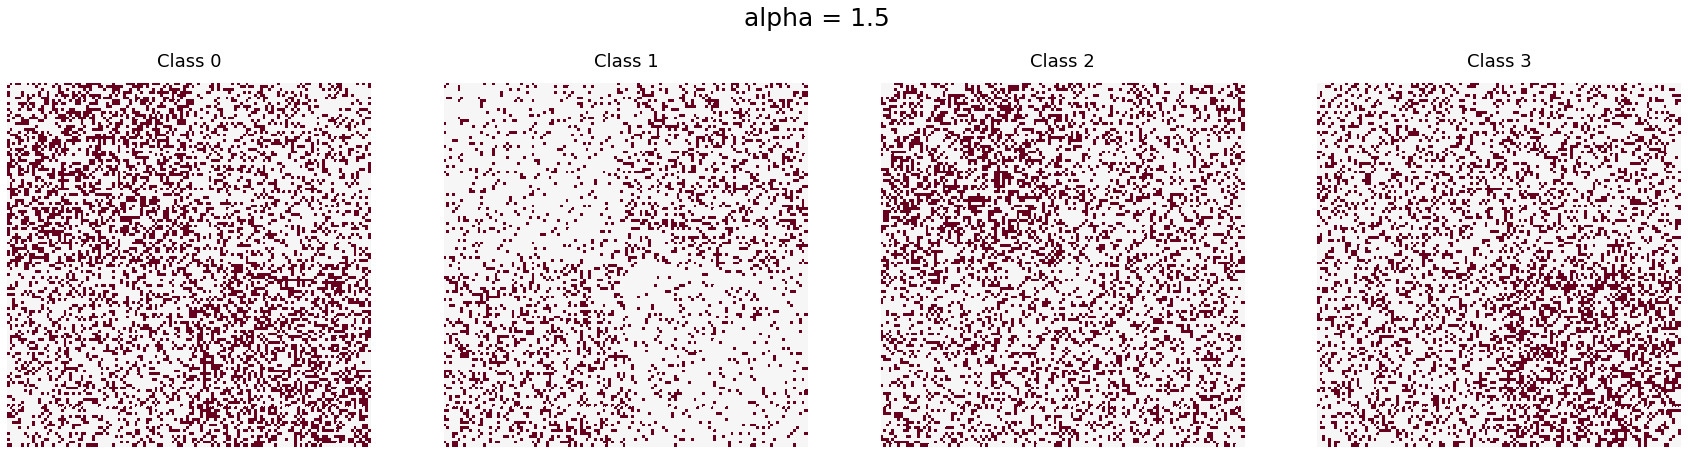

In [3]:
graphs, labels = generate_data(alpha=1.5)

fig, ax = plt.subplots(ncols=4, figsize=(30, 7.5))

for i, j in enumerate(range(0, 40, 10)):
    heatmap(graphs[j], ax=ax[i], cbar=False, title=f"Class {labels[j]}")

fig.suptitle("alpha = 1.5", fontsize=25)

In [4]:
# models
def run_grerf(XTRAIN, YTRAIN, XTEST, YTEST):
    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="Graph-Edge-MORF",
        max_features=20,
        n_jobs=6,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=128,
        image_width=128,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_classification(alpha):
    XTRAIN, YTRAIN = generate_data(alpha=alpha)
    XTEST, YTEST = generate_data(alpha=alpha)
    
    data = [XTRAIN, YTRAIN, XTEST, YTEST]

    grerf_error = run_grerf(*data)

    return grerf_error

In [5]:
alphas = np.arange(0, 2.01, .05)

runs = []
for _ in tqdm(range(50)):
    errors = []
    for alpha in alphas:
        errors.append(run_classification(alpha))
    runs.append(errors)

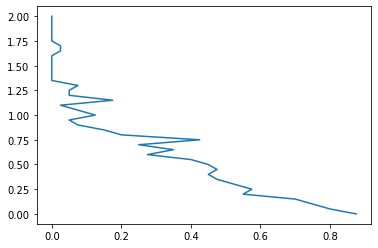

In [81]:
plt.figure()
plt.plot(runs[0],alphas)
plt.show()
# res = np.hstack([res, np.tile(alphas, 50).reshape(-1, 1)])

# columns = ['G-RerF', 'Alpha']
# df = pd.DataFrame(res, columns=columns)
# df_ = df.melt(id_vars='Alpha', value_vars=columns[0])
# # df_ = df.melt(id_vars='Alpha', value_vars=columns[:5])

# df.to_csv("results_grerf.csv", index=False)

# with sns.plotting_context("talk"):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.lineplot(data=df_, x = 'Alpha', y='value', hue='variable', ax=ax)
#     ax.set_ylabel("Misclassification Rate")
#     ax.set_xlabel("Alpha (Effect Size)")